# Решение задачи линейной регрессии с применением бутстрап-выборок

### Белоусова Ольга, Б03-904

Требуется построить модель для решения задачи линейной регрессии. После обучения модели по всей обучающей выборке необходимо провести исследование на бутстрап-выборках. Определить оптимальный размер  бутстрап выборки.

**Тип задачи** — обучение с учителем.

**Вид задачи** — линейная регрессия.

**Признаковое описание объектов** — действительные числа $\mathit{x_1, x_2, x_3, x_4}$, размерность 4.

**Целевая переменная** — действительное число $\mathit{y}$, размерность 1.

**Функция потерь** — стандартное отклонение $\mathit{std(\theta)}$, оно же *mean squared error (MSE)*.

**Мера качества** — обратная функция потерь. Чем меньше $-\mathit{std(\theta)}$, тем лучше модель.

**Мера неопределенности качества модели** — оценка доверительного интервала для качества модели с уровнем доверия 0.95.




## Часть 1. Создание и обучение модели

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
import datetime
from tqdm import tqdm

plt.rcParams['xtick.labelsize'] = 4
plt.rcParams['ytick.labelsize'] = 4

In [2]:
# Определяем класс линейной регрессии

class linear_regression:
    def __init__(self):
        self.theta = None
        pass
    
    def fit(self, X, y):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert ((y.ndim == 2)&(y.shape[1] == 1)), "y should be 2-dimensional: (N of objects, one column)"
        
        # attaching ones as first column-vector - x[:,0]
        X_0 = np.ones((X.shape[0], 1), dtype=np.float)
        X_matrix = np.concatenate([X_0, X], axis=1)
        
        # making y_train of shape (N,1)
        y_column = np.squeeze(np.asarray(y)).reshape((-1,1))
        
        m1 = np.dot(X_matrix.T, X_matrix)
        m2 = np.linalg.inv(m1)
        m3 = np.dot(m2, X_matrix.T)
        theta_star = np.dot(m3, y_column)
        self.theta = theta_star
    
    def predict(self, X):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert self.theta is not None, "theta is None. perhaps, fit the model first."
        
        X_0 = np.ones((X.shape[0], 1))
        X_matrix = np.concatenate([X_0, X], axis=1)
        y_pred = np.dot(X_matrix, self.theta)
        return y_pred

In [3]:
# Загрузка данных

X = np.load('./X_train.npy')
y = np.load('./y_train.npy')
print('Array "X" dimensions: ', X.shape)
print('Array "y" dimensions: ', y.shape)

Array "X" dimensions:  (10000, 4)
Array "y" dimensions:  (10000, 1)


###### Построим графики распределения признаков от целевой переменной по обучающей выборке, чтобы оценить общий вид зависимости.

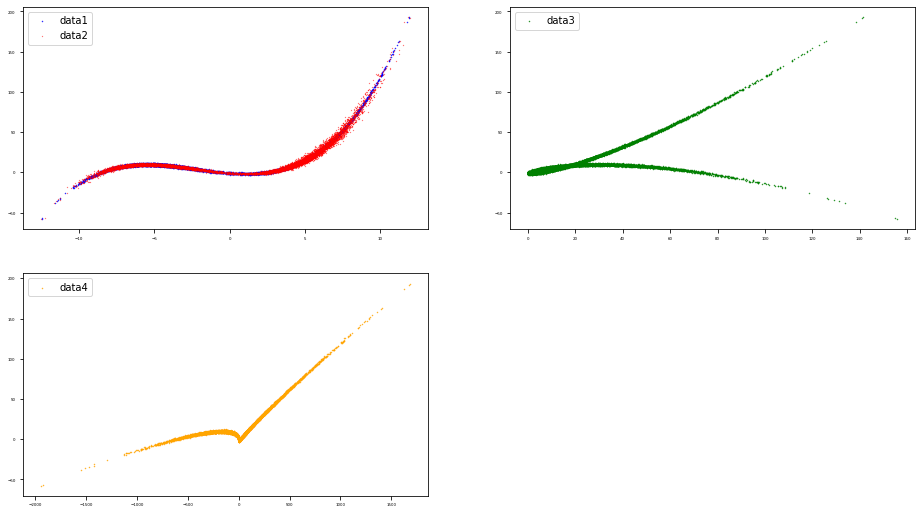

In [4]:
fig = plt.figure(figsize=(16, 9))

P = fig.add_subplot(2, 2, 1)
P = plt.scatter(X[:, 0], y, color = 'blue', label = 'data1', s = 0.2)
P = plt.scatter(X[:, 1], y, color = 'red', label = 'data2', s = 0.05)
P = plt.legend()

P = fig.add_subplot(2, 2, 2)
P = plt.scatter(X[:, 2], y, color = 'green', label = 'data3', s = 0.2)
P = plt.legend()

P = fig.add_subplot(2, 2, 3)
P = plt.scatter(X[:, 3], y, color = 'orange', label = 'data4', s = 0.2)
P = plt.legend()

###### Линейная регрессия. 
Получаем значение $\theta$ для данных из обучающей выборки:

In [5]:
lr = linear_regression()
lr.fit(X,y)

In [6]:
theta = lr.theta
print(theta)

[[-0.98643434]
 [-0.70247201]
 [-0.73652729]
 [ 0.53441968]
 [ 0.08096281]]


Оценим функцию потерь — стандартное отклонение — для обучающего набора.

In [29]:
y_learn = lr.predict(X)
mean_error_0 = np.mean(y-y_learn)
MSE_0 = np.std((y-y_learn))
print(mean_error_0)
print(MSE_0)

-7.898037779341394e-14
0.7117100500481706


###### Тестовая выборка.
Возьмём 100 случайных наборов данных, сделаем то же самое для этого нового набора и оценим функцию потерь тестовой выборки.

In [30]:
random_ind = np.random.permutation(X.shape[0])
random_index = random_ind[:100]

X_test = np.squeeze(X[[random_index],:])
X_00 = np.ones((X_test.shape[0], 1))
y_test = y[random_index]

In [31]:
y_pred = lr.predict(X_test)
mean_error = np.mean(y_pred-y_test)
MSE_test = np.std(y_pred-y_test)
print(mean_error)
print(MSE_test)

-0.028089525775761296
0.7021626302074832


Как видим, функция ошибок, а с ней и мера качества модели, приблизительно совпали. 

Построим гистограмму распределения функции ошибок модели:

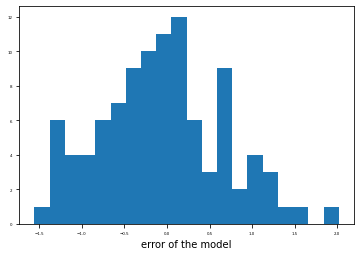

In [10]:
P = plt.hist((y_pred-y_test), bins=20)
P = plt.xlabel('error of the model')

При некоторых наборов данных распределение может визуально достаточно сильно отличаться от общего вида нормального распределения. Это объясняется небольшим размером тестовой выборки. 

Тем не менее, пик всегда приходится где-то на центральную часть графика.

## Часть 2. Бутстрап-выборки. Визуализация

Метод сэмплирования (создания новых образцов) из выборки, предоставляющий возможность оценивать статистики на сокращенной выборке. 

Два главных параметра бутстрап-выборки это $\mathit{B}$ — количество раз, сколько мы производим сэмплирование, и $\mathit{N}$ — размер каждой отдельной bootstrap-выборки .

В нашем случае размер полного массива данных — 1000 точек, а размеры бутстрап-выборок $\mathit{N = 10, 100, 200}$ (см. ниже).

In [11]:
# Определим функцию получения образцов бутстрапа:

def sample_bootstrap(X, y, sample_size, return_OOB_sample = False):
    sample_indices = np.random.randint(0, X.shape[0], sample_size)
    if return_OOB_sample:
        oob_indices = np.array([i for i in np.arange(0, X.shape[0], 1, dtype=int) if i not in sample_indices])
        return X[sample_indices, :], y[sample_indices, :], X[oob_indices, :], y[oob_indices, :]
    else:
        return X[sample_indices, :], y[sample_indices, :]

In [12]:
# Задаём параметр B.

B = 1000

In [13]:
# Определим функцию, которая возвращает массив бутстрап-выборки:

def bootstrap_sample_size(X, y, B, sample_size):
    # Генерируем линейную регрессию, получаем параметр Θ:
    
    theta_bootstrap = []
    for i in tqdm(range(B), total=B):
        X_train, y_train = sample_bootstrap(X, y, sample_size = sample_size)
        lr = linear_regression()
        lr.fit(X_train,y_train)
        theta_bootstrap.append(np.copy(lr.theta))
    theta_bsarray = np.concatenate([t.T for t in theta_bootstrap], axis=0)
    return theta_bsarray

In [14]:
# Определим также функцию, которая строит визуализацию наших бутстрап-выборок:

def bootstrap_sample_size_plot(X, y, B, sample_size, def_font_size = 6, def_linewidth = 0.5):
    # Генерируем линейную регрессию, получаем параметр Θ:
    
    theta_bootstrap = []
    for i in tqdm(range(B), total=B):
        X_train, y_train = sample_bootstrap(X, y, sample_size = sample_size)
        lr = linear_regression()
        lr.fit(X_train,y_train)
        theta_bootstrap.append(np.copy(lr.theta))
    theta_bsarray = np.concatenate([t.T for t in theta_bootstrap], axis=0)
    
    #А теперь строим график:
    
    fig = plt.figure(figsize=(4, 6), dpi=300)
    for i in range(theta.shape[0]):
        P = plt.subplot(3,2, i+1)
        P = plt.title("$\\theta_%d$" % i, fontdict = {'fontsize': def_font_size})
    
        h_counts, h_bins, P = plt.hist(theta_bsarray[:,i], bins=30, color='white', ec="black", linewidth = def_linewidth)
        mean_theta_i = np.mean(theta_bsarray[:,i])
        std_theta_i = np.std(theta_bsarray[:,i])
    
        P = plt.vlines(mean_theta_i, 0, h_counts.max(), color='magenta')
        P = plt.vlines(theta[i,0], 0, h_counts.max(), color='green')
        P = plt.text(mean_theta_i, 3*h_counts.max()/4, '$mean(\\theta_%d) = %.3f$' % (i, mean_theta_i), fontsize = def_font_size)
        P = plt.text(mean_theta_i, 2*h_counts.max()/4, '$std(\\theta_%d) = %.3f$' % (i, std_theta_i), fontsize = def_font_size)
        P = plt.text(mean_theta_i, 1*h_counts.max()/4, '$\\theta_%d = %.3f$' % (i, theta[i,0]), fontsize = def_font_size, color='green')
    
    P = plt.tight_layout()

##### Визуализация вычисления неопределённостей модели на бутстрап-выборках в 10, 100 и 1000 экземпляров

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 8263.97it/s]


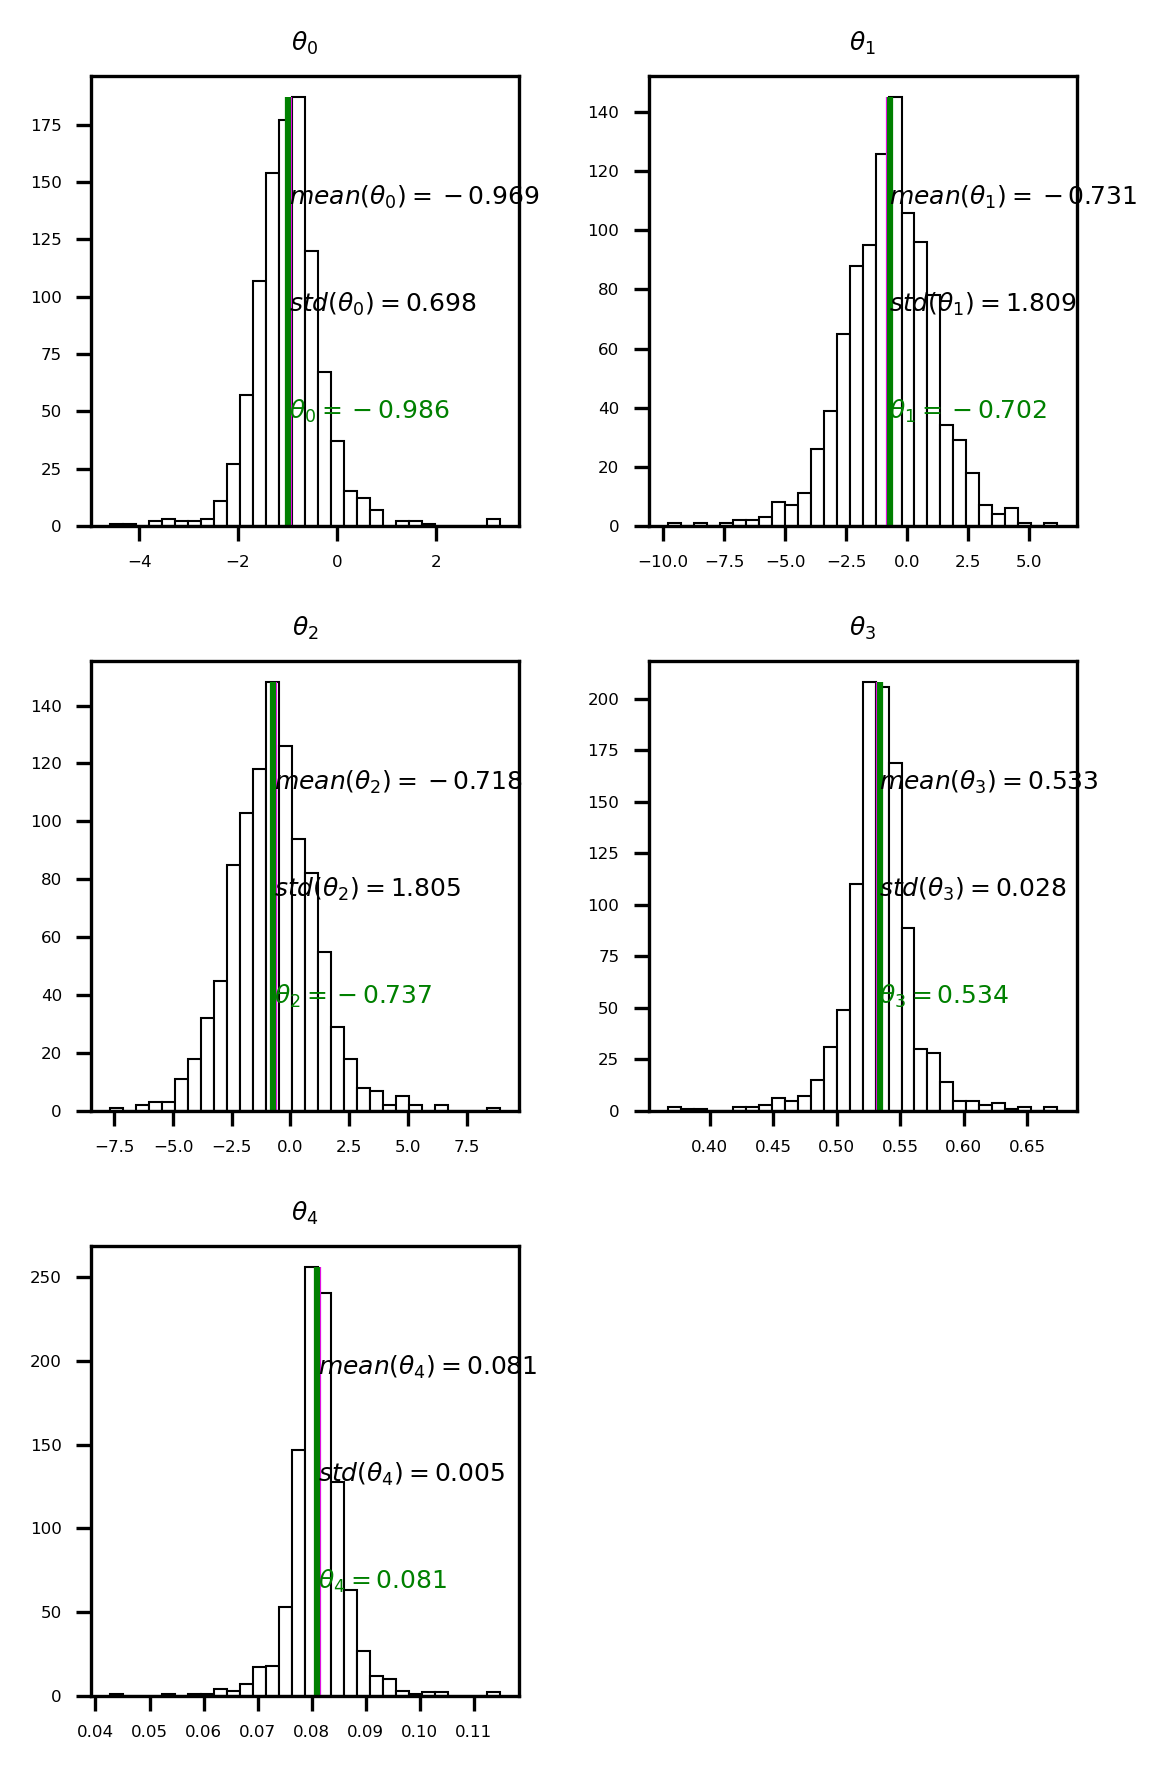

In [15]:
bootstrap_sample_size_plot(X, y, B, 10)

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 6578.57it/s]


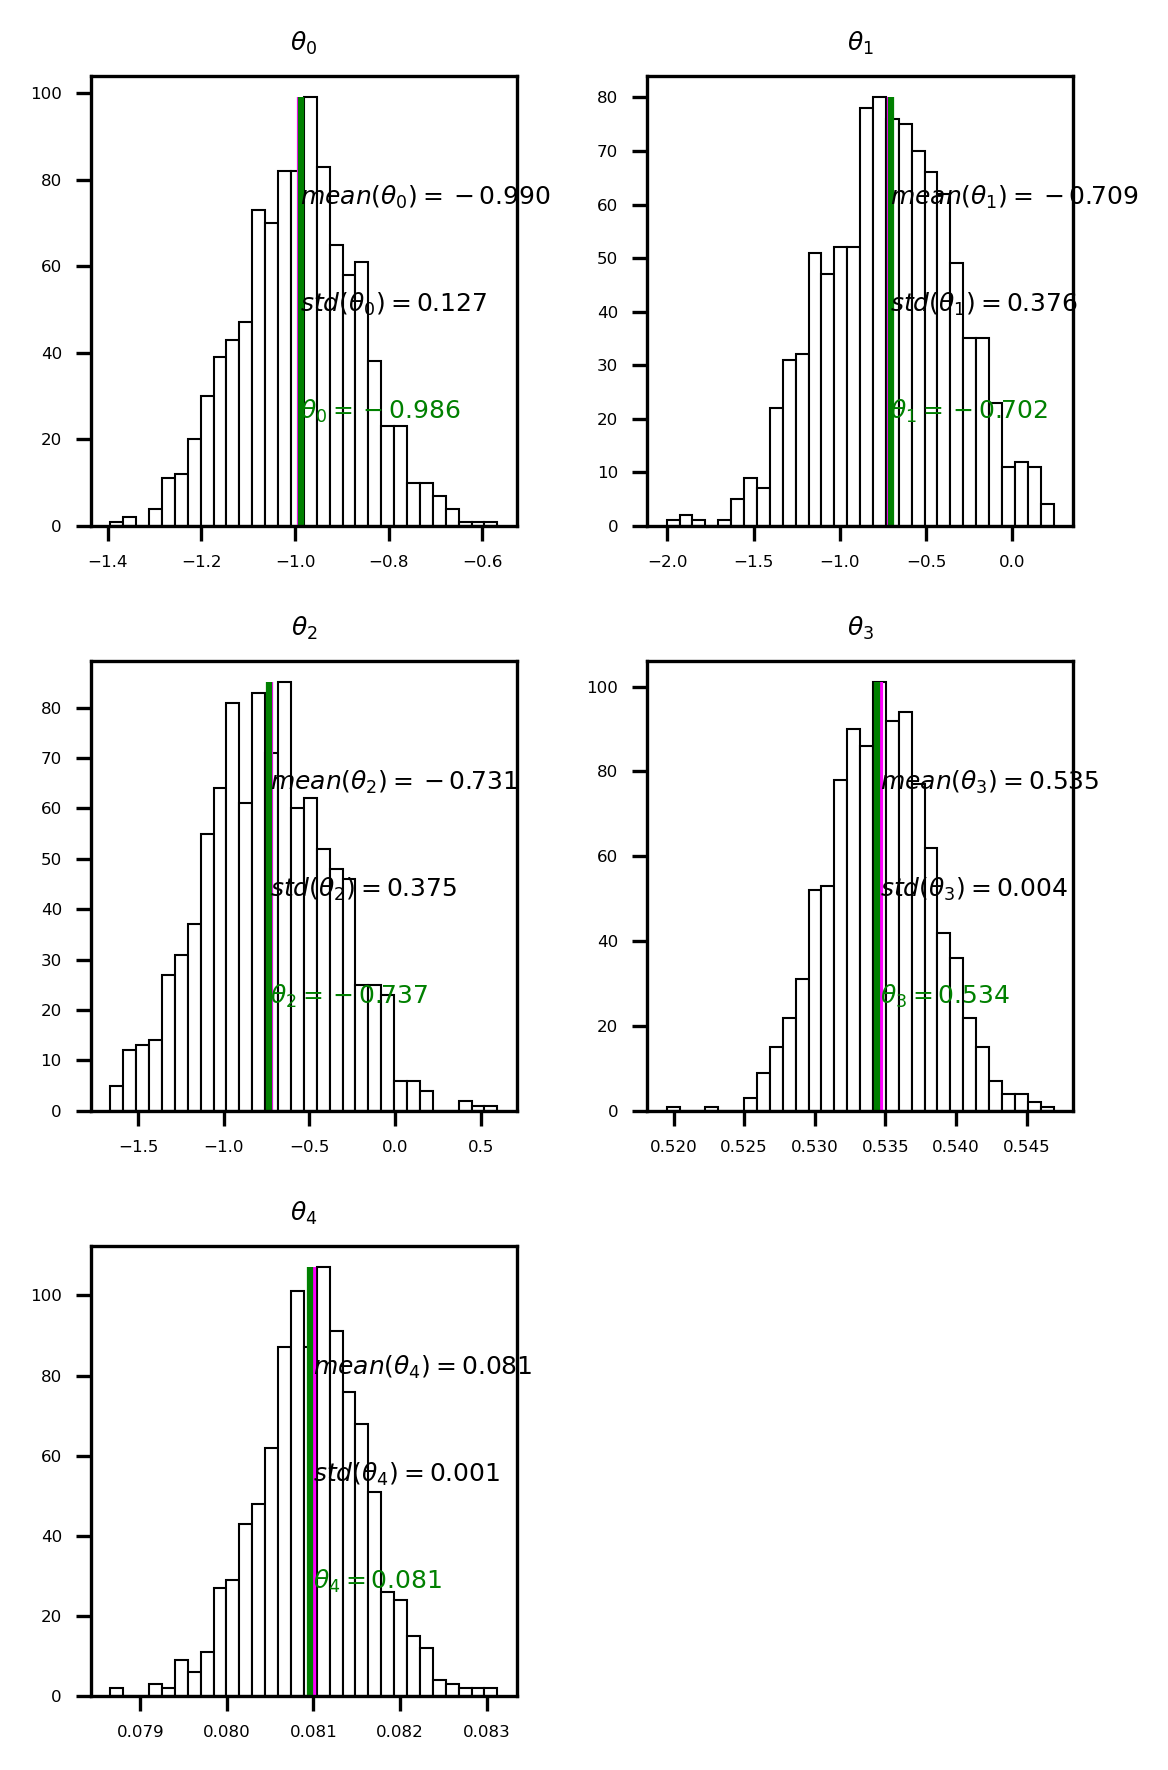

In [16]:
bootstrap_sample_size_plot(X, y, B, 100)

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 3545.90it/s]


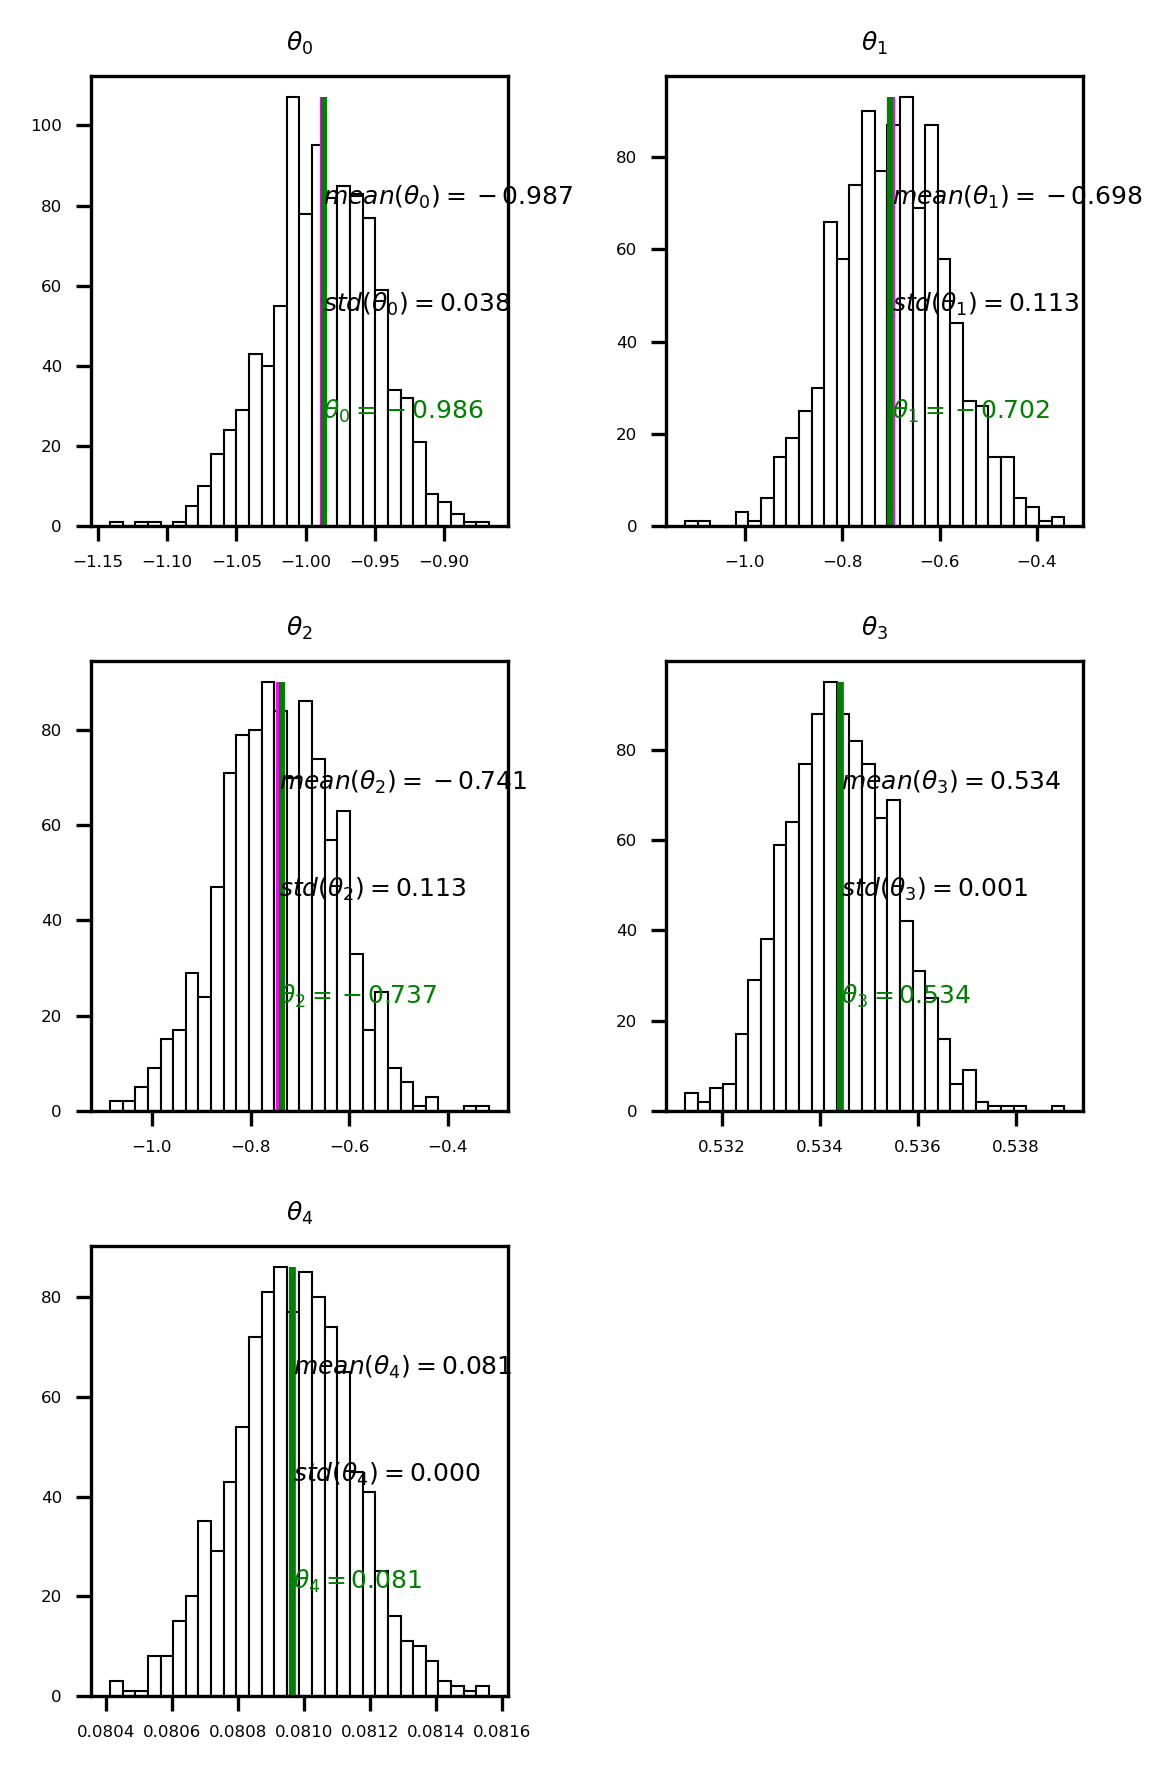

In [17]:
bootstrap_sample_size_plot(X, y, B, 1000)

## Часть 3. Оценка неопределённости модели.

С ростом числа экземпляров (сэмплов) в бутстрап-выборке неопределённость данных снижается. В качестве меры неопределённости проще всего взять стандартное отклонение ($\mathit{std(\theta)}$). При увеличении размера отдельных бутстрап-выборок $\mathit{N}$ до бесконечности стандартная ошибка в теории выйдет на некую асимптоту — алеаторической ошибке.

Проще всего это увидеть при помощи визуализации. Построим график зависимости $\mathit{std(\theta)}$ от N для заданных значений N.

In [18]:
theta_values_per_sample_size = []
#test_range_for_bs = [10, 20, 25, 30, 35, 40, 50]
test_range_for_bs = [10, 25, 50, 100, 200, 500, 1000, 2000, 4000, 10000]
for sample_size in test_range_for_bs:
    theta_values_curr_sample_size = []
    for i in tqdm(range(B), total = B):
        X_train, y_train = sample_bootstrap(X, y, sample_size = sample_size)
        lr = linear_regression()
        lr.fit(X_train,y_train)
        theta_values_curr_sample_size.append(np.copy(lr.theta))
    theta_values_curr_sample_size = np.concatenate([t.T for t in theta_values_curr_sample_size], axis=0)
    theta_values_per_sample_size.append({'sample_size': sample_size, 'theta_values': theta_values_curr_sample_size})

100%|█████████████████████████████████████| 1000/1000 [00:01<00:00, 594.50it/s]


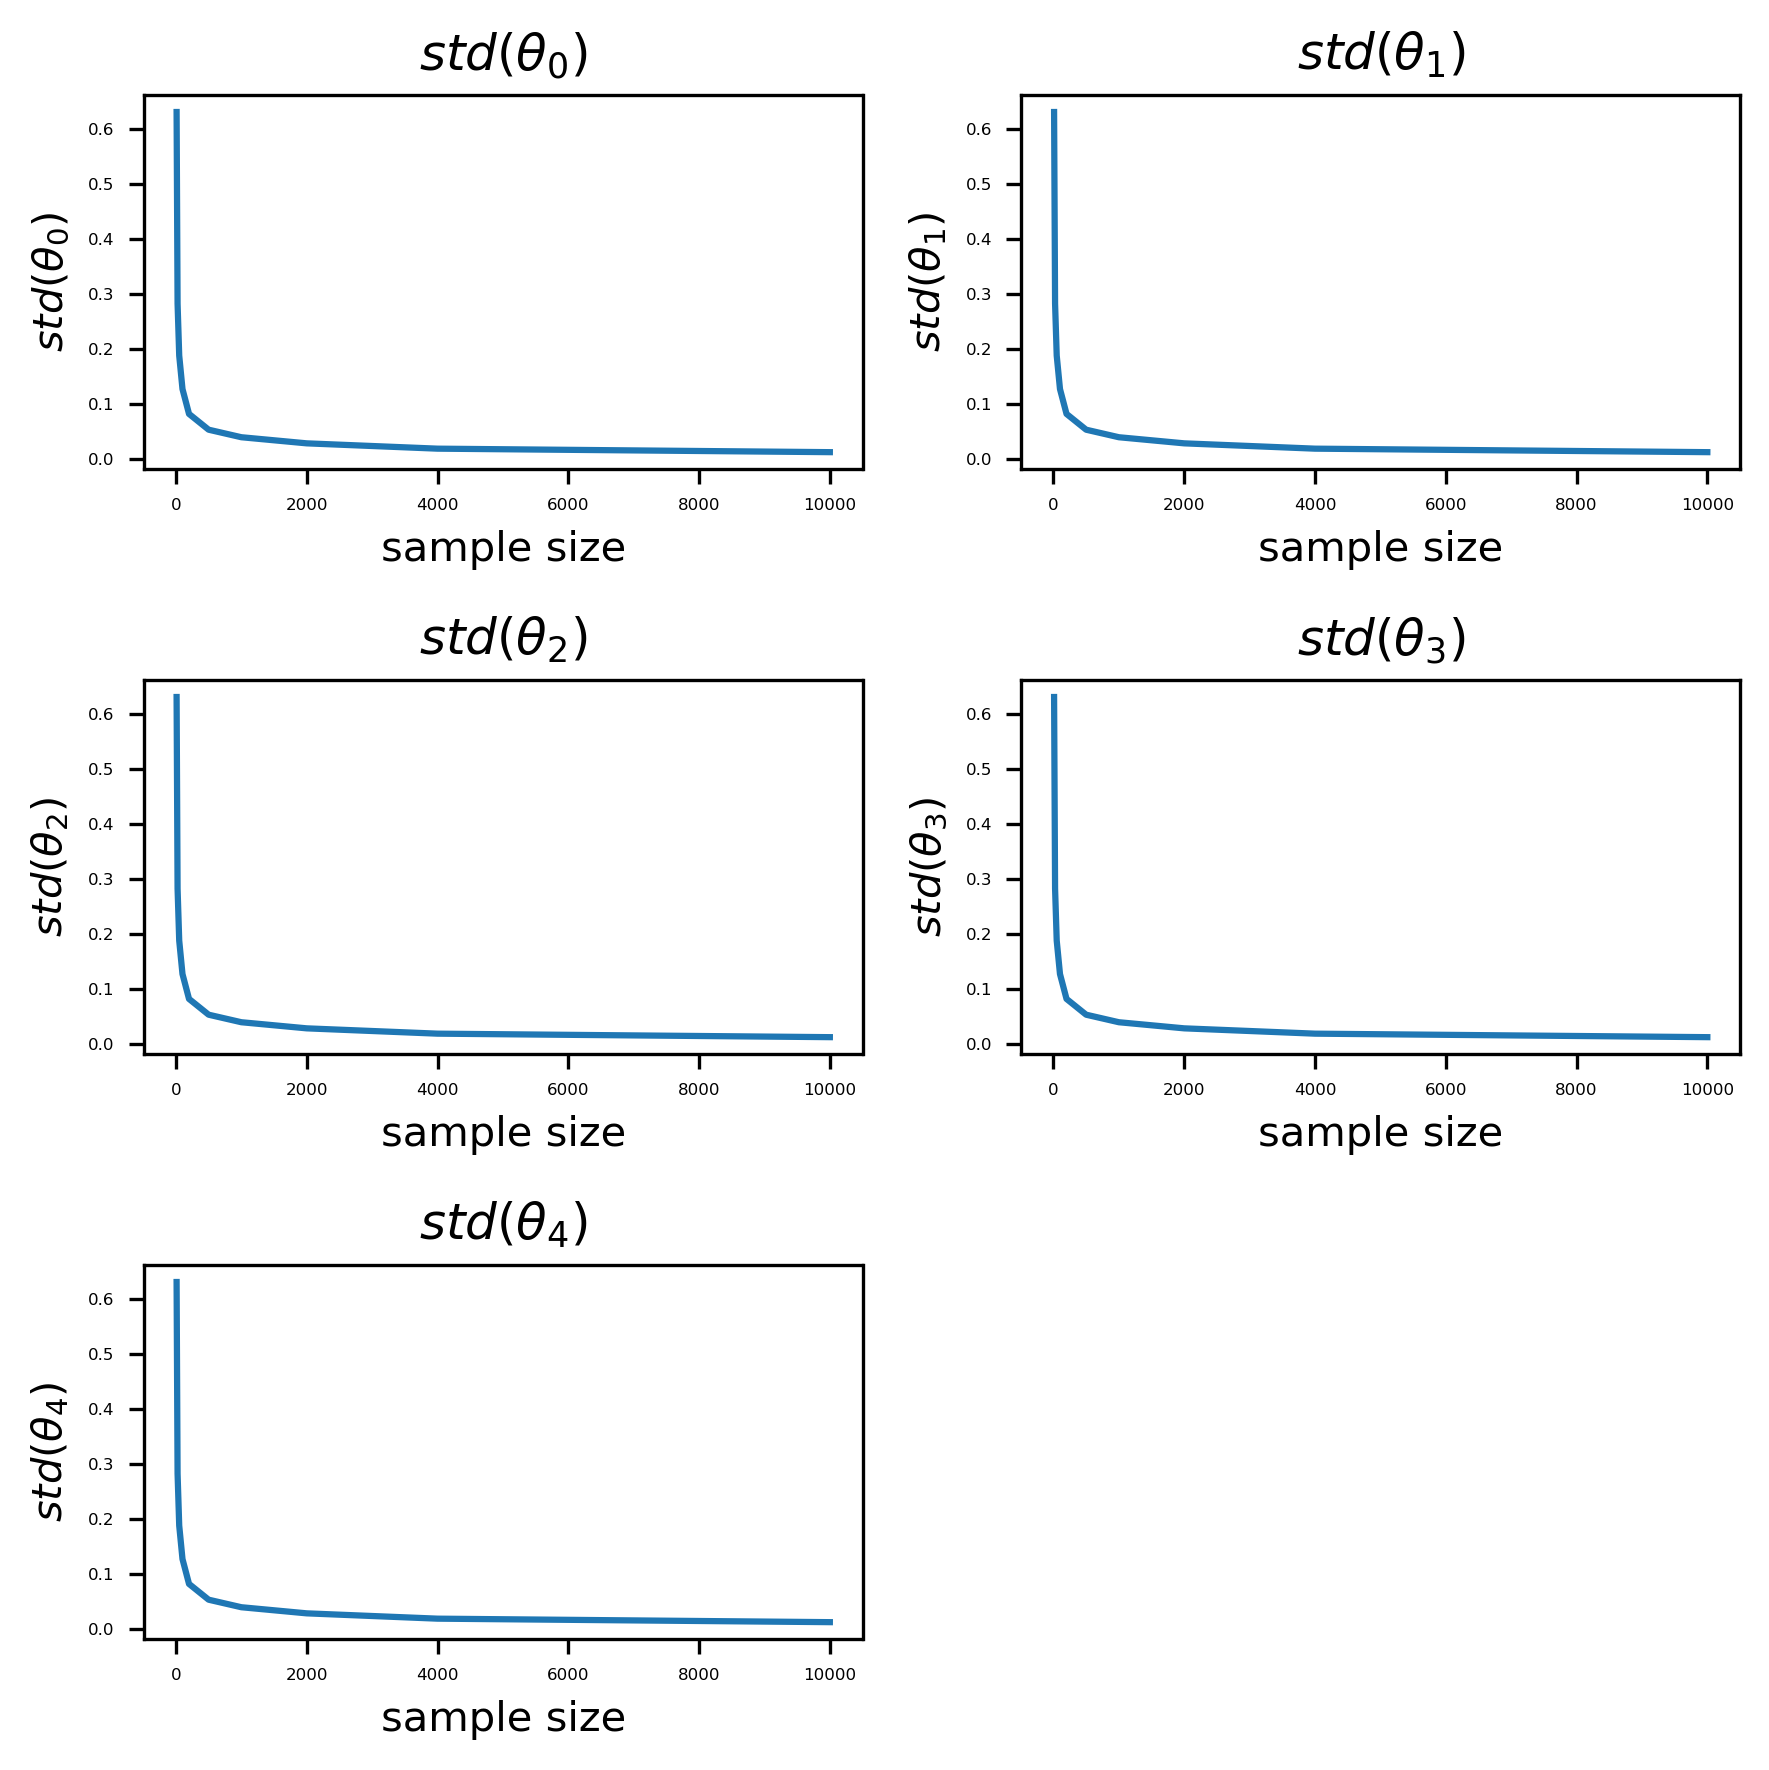

In [19]:
fig = plt.figure(figsize=(6,6), dpi=300)
for i in range(5):
    P = plt.subplot(3,2,i+1)
    P = plt.plot([t['sample_size'] for t in theta_values_per_sample_size],
                 [np.std(t['theta_values'][:,0]) for t in theta_values_per_sample_size],
                 label='$std(\\theta_%d)$' % i)
    #P = plt.axvline(x = 10, color ="green", linestyle ="--", linewidth = 0.4)
    #P = plt.axhline(y = theta[i, 0], color ="green", linestyle ="--", linewidth = 0.4)
    P = plt.ylabel('$std(\\theta_%d)$' % i)
    P = plt.xlabel('sample size')
    P = plt.title('$std(\\theta_%d)$' % i)
plt.tight_layout()

Оценочно, взглянув на графики, можно видеть, что где-то начиная с размера выборки, равной 2000, модель начинает насыщаться. Теперь оптимизируем по другому параметру — количеству выборок $\mathit{B}$.

Возьмём значения $\mathit{B = 100, 200, 300}$.

##### Доверительный интервал

По условию составляет 95%. То есть это такой интервал в окрестности среднего значения распределения нашей величины, в который попадут 95% измерений. 

По формуле ожидаемой доля измерений внутри диапазона, получаем:

$$p = \operatorname{erf}\left(\frac{x}{\sqrt{2}}\right) = 0.95 \rightarrow x \approx 1.96,$$

или же, другими словами, доверительный интервал в 95% равен 1.96 сигма-интервалов в обе стороны от среднего значения.

##### Критерий оценки попадания в доверительный интервал

Из всего полученного набора данных бутстрапа возьмём крайние 5%: по 2.5 процента наименьших и по 2.5% наибольших. Проверим, входят ли оставшиеся данные в доверительный интервал.

In [20]:
test_range_for_bs1 = [500, 1000, 2000]
sample_size = 2000
for bootstrap_quantity in (test_range_for_bs1):    
    M = bootstrap_sample_size(X, y, bootstrap_quantity, sample_size)
    min_index = int(bootstrap_quantity*0.025) + 1
    max_index = int(bootstrap_quantity*0.975) - 1
    
    theta_bootstrap = []
    for i in range(bootstrap_quantity):
        X_train, y_train = sample_bootstrap(X, y, sample_size=sample_size)
        lr = linear_regression()
        lr.fit(X_train,y_train)
        theta_bootstrap.append(np.copy(lr.theta))
    theta_bsarray = np.concatenate([t.T for t in theta_bootstrap], axis=0)
    
    print('Confidence interval for B =', bootstrap_quantity, 'and sample_size =', sample_size, ':')
    for i in range(theta.shape[0]):
        M[:,i].sort()
        mean_theta = np.mean(theta_bsarray[:,i])
        std = np.std(theta_bsarray[:,i])
        print(M[min_index, i])
        print(mean_theta)
        print(std)
        print(M[max_index, i])
        flag = (M[min_index, i] > mean_theta - abs(std)*1.96) and (M[max_index, i] < mean_theta + abs(std)*1.96)
        print('i =', i, ': {', mean_theta - std*1.96, mean_theta + std*1.96, '};', 'Is it inside?', flag)

 20%|███████▎                             | 196/1000 [00:00<00:00, 1940.48it/s]

Confidence interval for B = 500 and sample_size = 2000 :
-1.0333190071674734
-0.9861528596468613
0.02827722361669298
-0.9334314458408063
i = 0 : { -1.0415762179355794 -0.930729501358143 }; Is it inside? True
-0.862557702796823
-0.7007562230449307
0.07975255296928015
-0.5497278093478626
i = 1 : { -0.8570712268647198 -0.5444412192251415 }; Is it inside? False
-0.8892330121876065
-0.7382015645747121
0.07922779244733075
-0.578011154220275
i = 2 : { -0.8934880377714803 -0.5829150913779438 }; Is it inside? False
0.5327573638967684
0.5344358638023661
0.0008078703309953077
0.5358094703691012
i = 3 : { 0.5328524379536153 0.5360192896511169 }; Is it inside? False
0.08072023403818986
0.08096070381739526
0.00011768005070987977
0.08121175897272535
i = 4 : { 0.08073005091800389 0.08119135671678662 }; Is it inside? False


 14%|█████▏                               | 279/2000 [00:00<00:00, 2789.84it/s]

Confidence interval for B = 1000 and sample_size = 2000 :
-1.0391263446866403
-0.9860624563451871
0.026358458248919827
-0.9346997890553792
i = 0 : { -1.03772503451307 -0.9343998781773042 }; Is it inside? False
-0.8640713867068377
-0.7039310224701378
0.07979707236754413
-0.5456168257991024
i = 1 : { -0.8603332843105244 -0.5475287606297513 }; Is it inside? False
-0.890620731543107
-0.7350170762275559
0.0794241515785149
-0.5820725006710652
i = 2 : { -0.890688413321445 -0.5793457391336667 }; Is it inside? True
0.5329906881509312
0.5344200557369364
0.0007332526199027047
0.5359085215302951
i = 3 : { 0.5329828806019271 0.5358572308719457 }; Is it inside? False
0.08071782481962939
0.08096270790905931
0.00012657843919510053
0.08120582559052567
i = 4 : { 0.08071461416823691 0.0812108016498817 }; Is it inside? True


100%|████████████████████████████████████| 2000/2000 [00:00<00:00, 2590.52it/s]


Confidence interval for B = 2000 and sample_size = 2000 :
-1.0399139820709258
-0.9863093769910839
0.027290173007033323
-0.932884659702725
i = 0 : { -1.0397981160848693 -0.9328206378972986 }; Is it inside? False
-0.8559185648461992
-0.7052648109669654
0.0815182882597886
-0.5475821663486937
i = 1 : { -0.865040655956151 -0.5454889659777797 }; Is it inside? True
-0.8879491798707567
-0.7335300417178713
0.08134949781634747
-0.581878485687014
i = 2 : { -0.8929750574379123 -0.5740850259978303 }; Is it inside? True
0.5329349074908416
0.5344319007400815
0.0007810998561042839
0.5360065695964416
i = 3 : { 0.5329009450221172 0.5359628564580459 }; Is it inside? False
0.08072269146716256
0.08095758605199639
0.00012542478640522204
0.0812119720408047
i = 4 : { 0.08071175347064216 0.08120341863335062 }; Is it inside? False


Видим, что для B = 50 и B = 100 ещё не все значения попадают в доверительный интервал. А вот начиная с B = 150 критерий оптимального количества bootstrap-выборок срабатывает.

Итого наше приближение оптимальных параметров бутстрапа для наших данных: **$\mathit{B = 150}$** и **$\mathit{N = 1000.}$**

Теперь оценим средние значения и неопределенности для параметров модели с использованием оптимальных количества и размера bootstrap-выборок. На графике это значения $\mathit{mean({\theta}_0)}$ и $\mathit{std({\theta}_0)}$.

100%|██████████████████████████████████████| 150/150 [00:00<00:00, 3571.22it/s]


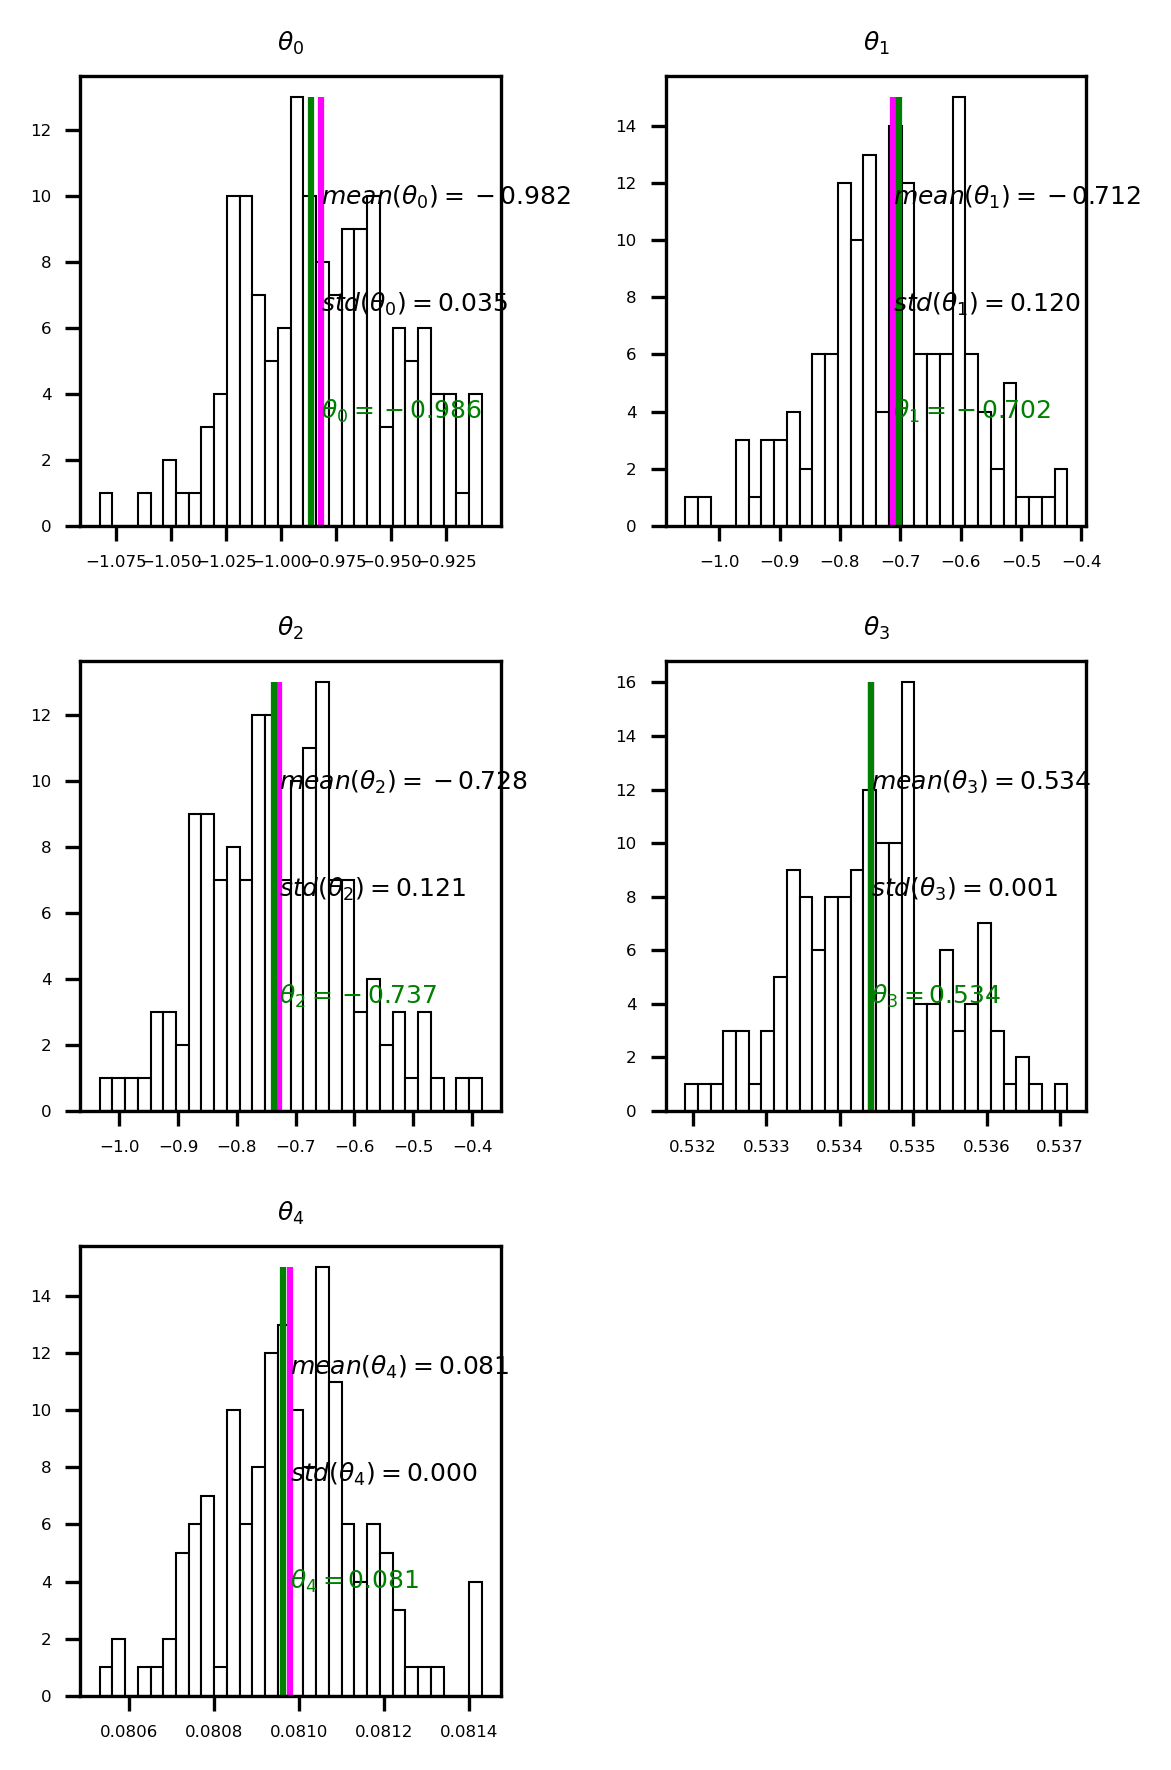

In [21]:
bootstrap_sample_size_plot(X, y, 150, 1000)

##### Оценка качества модели

Сравним функцию ошибок от бутстрап-выборки с такой же от тестовой выборки.

In [22]:
random_ind = np.random.permutation(X.shape[0])
random_index = random_ind[:150]

X_test = np.squeeze(X[[random_index],:])
X_00 = np.ones((X_test.shape[0], 1))
y_test = y[random_index]

y_pred = lr.predict(X_test)
MSE_test = np.std((y_pred-y_test))
print(MSE_test)

0.7083258957922753


In [23]:
X_bs, y_bs = sample_bootstrap(X, y, 150)
y_pred1 = lr.predict(X_bs)
MSE_bs = np.std((y_pred1-y_bs))
print(MSE_bs)

0.6821782539108749


Значения довольно близки. Ошибка у бутстрап-выборки ожидаемо слегка выше.

##### Оценка неопределенности качества модели

Просэмлируем 

## Часть 4. Аппроксимация целевой переменной на выборке вновь поступающих объектов

Загрузим новые данные, применим модель, сделаем визуализацию, посчитаем ошибку на некоторой выборке, оценим доверительные интервалы.

In [24]:
X_inf = np.load('./X_inference.npy')
X_inf.shape

(100, 4)

In [25]:
X_inf_0 = np.ones((X_inf.shape[0],1))
X_inf_new = np.concatenate([X_inf_0, X_inf], axis = 1)
Y_inf_approximated = np.dot(X_inf_new, theta)

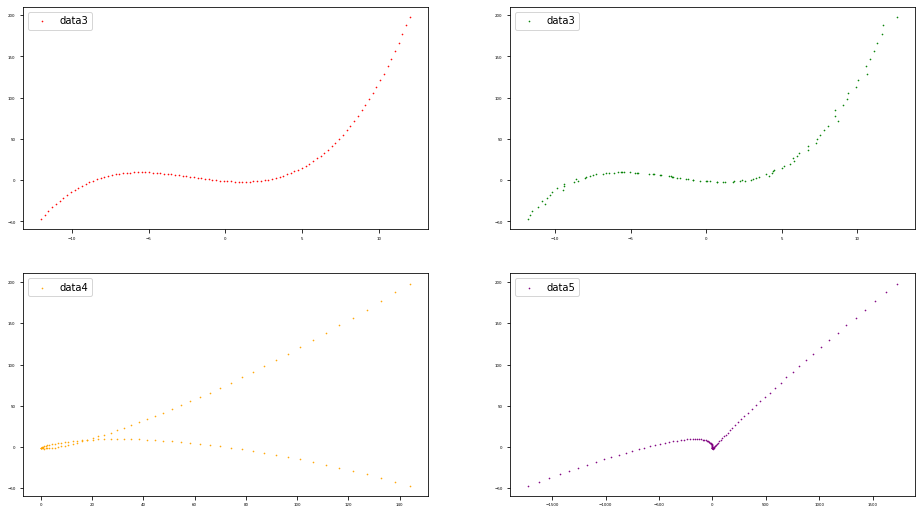

In [26]:
fig = plt.figure(figsize=(16, 9))

P = fig.add_subplot(2, 2, 1)
P = plt.scatter(X_inf_new[:, 1], Y_inf_approximated, color = 'red', label = 'data3', s = 0.4)
P = plt.legend()

P = fig.add_subplot(2, 2, 2)
P = plt.scatter(X_inf_new[:, 2], Y_inf_approximated, color = 'green', label = 'data3', s = 0.4)
P = plt.legend()

P = fig.add_subplot(2, 2, 3)
P = plt.scatter(X_inf_new[:, 3], Y_inf_approximated, color = 'orange', label = 'data4', s = 0.4)
P = plt.legend()

P = fig.add_subplot(2, 2, 4)
P = plt.scatter(X_inf_new[:, 4], Y_inf_approximated, color = 'purple', label = 'data5', s = 0.4)
P = plt.legend()

Построим гистограммы оценок целевой переменной:

In [27]:
lr = linear_regression()
lr.fit(X_inf,Y_inf_approximated)

mean_y = 25.173213628322557
MSE = 7.714710361856214e-12
Confidence interval: { 25.173213628307437 25.173213628337678 }


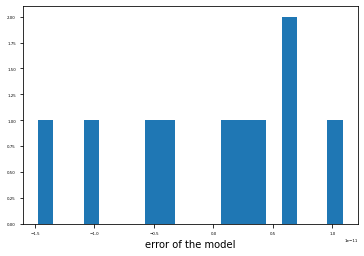

In [28]:
random_ind = np.random.permutation(X_inf_new.shape[0])
random_index = random_ind[:10]

X_test = np.squeeze(X_inf[[random_index],:])
X_00 = np.ones((X_test.shape[0], 1))
y_test = Y_inf_approximated[random_index]

y_pred = lr.predict(X_test)
MSE_test = np.std((y_pred-y_test))
mean_y = np.mean(Y_inf_approximated)
print('mean_y =', mean_y)
print('MSE =', MSE_test)
print('Confidence interval: {', mean_y - 1.96 * MSE_test, mean_y + 1.96 * MSE_test, '}')

P = plt.hist((y_pred-y_test), bins=20)
P = plt.xlabel('error of the model')

## Выводы

* **Насколько модель подходит для описания данных?** 

Соотношение меры качества на тренировочной и тестовой подвыборках близко к единице. В целом это означает, что модель хороша для описания наших данных.

* **Достаточно ли данных для оценки параметров модели?**

Так как данных довольно много, и они содержат относительно мало шума, модель оказывается весьма близкой к данным. Данных вполне достаточно, даже малые бутстрап-выборки дают хороший результат аппроксимации.

* **Наблюдаются ли явления переобучения или недообучения?**

Явления переобучения или недообучения, по всей видимости, не наблюдаются. Модель выразительна.